## Benchmark ##

Ensure long enough epochs, to test perfomrnace of various hyperparameters

* batchidx
* epochs
* learning rate

No early stopping rules in benchmark testing because we want enough epochs to see the performance trends.

In [1]:
import time
import random
import pandas as pd
import numpy as np
import math
import logging

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchvision import transforms, datasets, models
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data.dataset import random_split


### Data pre-processing pipeline ###

In [2]:
fname = "data/gt-weekly.zip"
dscol = 'time'
ycols = ['i1','i2','i3','i4','i5','i6','i7','i8','i9','i10']

In [3]:
from preprocessing.preprocessor import LoadData, FindFrequency, PeriodDetect, AlignData, DropExtrema, Normalizer, FillGap, GenerateInput
from pipeline import Pipeline

test_task_list = [
    LoadData(fname, dscol, ycols),
    FindFrequency(),
    PeriodDetect(),
    AlignData(),
    DropExtrema(),
    Normalizer(),
    FillGap(),
    GenerateInput()
]
test_pipeline = Pipeline(test_task_list)
dats, params = test_pipeline.transform()
dat_weekdays = dats[0]
dat_weekends = dats[1]

Using TensorFlow backend.
/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

Finding frequency:   0%|          | 0/2 [00:00<?, ?it/s]

(25200, 10)
(10080, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs'])
dict_keys(['minfreq', 'colfreqs'])


Detecting Period:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


(25200, 10)
(10080, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period'])
dict_keys(['minfreq', 'colfreqs', 'period'])


Aligning data:   0%|          | 0/2 [00:00<?, ?it/s]

(35279, 10)
(31679, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint'])


Dropping Extrema:   0%|          | 0/2 [00:00<?, ?it/s]

(35279, 10)
(31679, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint'])


Normalising:   0%|          | 0/2 [00:00<?, ?it/s]

(35279, 11)
(31679, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms'])


Filling gap:   0%|          | 0/2 [00:00<?, ?it/s]

ok10
ok20
ok11
ok21
(35279, 11)
(31679, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
(35279, 11)
(31679, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Generating Input:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
#AE structure
class AutoEncoder(nn.Module):
    def __init__(self, first_layer, layer_1, layer_2):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(first_layer, layer_1),
            nn.ReLU(),
            
            nn.Linear(layer_1,layer_2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(layer_2, layer_1),
            nn.ReLU(),
            
            nn.Linear(layer_1, first_layer)            
        )

    def forward(self, x):
        
        x_encoder = self.encoder(x)
        x_decoder = self.decoder(x_encoder)

        return x_encoder,x_decoder
    
#custom dataset
class ChronosDataset(Dataset):
    def __init__(self,dat):
        self.dat = dat
        
    def __len__(self):
        return len(self.dat)
    
    def __getitem__(self,idx):
        return self.dat[idx]

#Trainning function
def _fit(ae, train_loader, val_loader, epochs, batch_size, optimizer, lr, scheduler, loss_f, writer):
    val_loss_list = []
    loss_list = []
    
    for epoch in range(epochs):
        average_loss = 0.0
        for batchidx, x in enumerate(train_loader):
            x = Variable(x.float())
            _x_encoded, _x_decoded = ae(x.float())
            loss = loss_f(_x_decoded,x)
            average_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        average_loss = average_loss / batch_size
        loss_list.append(average_loss)
        writer.add_scalar(f'loss/{batch_size}_{epochs}_{lr}',average_loss, epoch)
        
        #Validation
        with torch.no_grad():
            average_val_loss = 0.0
            for batchidx, x in enumerate(val_loader):
                ae.eval()
                _x_encoded, _x_decoded = ae(x.float())
                val_loss = loss_f(_x_decoded,x)
                average_val_loss += val_loss.item()
            average_val_loss = average_val_loss / batch_size
            val_loss_list.append(average_val_loss)
            writer.add_scalar(f'val_loss/{batch_size}_{epochs}_{lr}',average_val_loss, epoch)
        
        if epoch % 100 == 0:
            print(f'epoch number:{epoch} train_loss: {average_loss} val_loss: {average_val_loss}')
        scheduler.step(average_loss)
         

    logging.info(f"Training finished, epoch runned: {epoch}")
    return loss_list, val_loss_list

# def load_checkpoint(model, checkpoint_PATH, optimizer):
#     if checkpoint != None:
#         model_CKPT = torch.load(checkpoint_PATH)
#         model.load_state_dict(model_CKPT['state_dict'])
#         print('loading checkpoint!')
#         optimizer.load_state_dict(model_CKPT['optimizer'])
#     return model, optimizer

In [5]:
def complement_memory_list(lst, max_size):
    if len(lst) == max_size:
        return lst
    
    nan_len = max_size - len(lst)
    complement = [None] * nan_len
    lst = lst + complement
    return lst

def model_benchmark(dat, epochs_list, lr_list, batchsize_list):
    from tqdm.notebook import trange, tqdm

    #prepare data
    train_len = int(len(dat) * 0.8)
    val_len = len(dat) - train_len
    train_dat, val_dat = random_split(dat, [train_len, val_len])
    writer = SummaryWriter()
    first_layer = dat.shape[1]
    layer_1 = max(math.floor(first_layer/4),30) #max(math.floor(n_inputs/4), 30)
    layer_2 = max(math.floor(layer_1/4),15) #max(math.floor(n_units_1/4), 15)

#     model_candidates = []
#     loss_list = []
#     hyperparameter_list = []
#     file_order = 0
    loss_memory = pd.DataFrame()
    val_loss_memory = pd.DataFrame()
    max_epoch = max(epochs_list)
    
    for batch_size in tqdm(batchsize_list):
        for lr in tqdm(lr_list):
            for epochs in tqdm(epochs_list):
            #     tolerence_percentage = (i + 1) / 10.0
            #     tolerence = EPOCHS * tolerence_percentage
                train_loader = DataLoader(ChronosDataset(train_dat), batch_size, True)
                val_loader = DataLoader(ChronosDataset(val_dat), batch_size, True)
                ae = AutoEncoder(first_layer, layer_1, layer_2)
                optimizer = torch.optim.Adam(ae.parameters(), lr=lr)
                scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.5, patience=125, verbose=True)
                loss_f = nn.MSELoss()

                loss_list, val_loss_list = _fit(ae, train_loader, val_loader, epochs, batch_size, optimizer, lr, scheduler, loss_f, writer)
                loss_list = complement_memory_list(loss_list,max_epoch)
                val_loss_list = complement_memory_list(val_loss_list,max_epoch)
                column_name = f'{batch_size}_{lr}_{epochs}'
                loss_memory[column_name] = loss_list
                val_loss_memory[column_name] = val_loss_list
#                 filename = f"temperary_model/temp_model_{file_order}"

#                 model_candidates.append(filename)
#                 loss_list.append(best_loss)
#                 hyperparameter_list.append((lr,epochs,tolerence))

#                 try:
#                     torch.save(best_ae,filename)
#                 except Exception as e:
#                     raise ValueError(e)

#                 file_order += 1
                                
#     losses = np.array(loss_list)
#     min_loss = losses.argmin()
#     ae = torch.load(model_candidates[min_loss])
#     ae.eval()

#     print(loss_list[min_loss])
#     print(hyperparameter_list[min_loss])
#     print(ae.state_dict())
    return loss_memory, val_loss_memory

## Define Hyperparameter settings ##

In [6]:
epochs_list = [10, 100]
lr_list = [0.01, 0.001]
batchsize_list = [32]

## For Weekday model ##

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch number:0 train_loss: 36843.59282613732 val_loss: 17.903528895982365
epoch number:0 train_loss: 36730.053791687824 val_loss: 14.13454683428766


  0%|          | 0/2 [00:00<?, ?it/s]

epoch number:0 train_loss: 0.029352433048188686 val_loss: 0.010094933231980444
epoch number:0 train_loss: 0.02609049342572689 val_loss: 0.00945256403327244


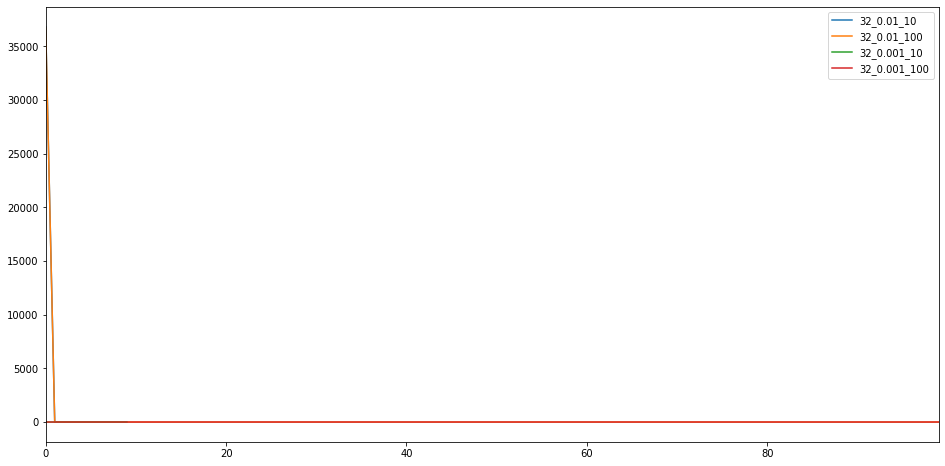

In [7]:
loss_memory, val_loss_memory = model_benchmark(dat_weekdays, epochs_list, lr_list, batchsize_list)
loss_memory.plot(figsize=[16,8])

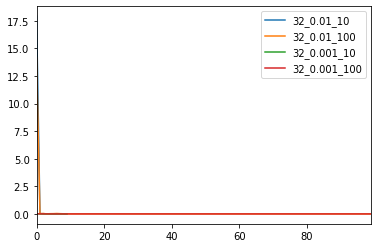

In [8]:
val_loss_memory.plot()

## For Weekends model ##

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch number:0 train_loss: 32947.20766720176 val_loss: 33.74215759101151
epoch number:0 train_loss: 51909.34044301696 val_loss: 21.75057836386036


  0%|          | 0/2 [00:00<?, ?it/s]

epoch number:0 train_loss: 0.02928251214325428 val_loss: 0.010884153311648648
epoch number:0 train_loss: 0.02756863832473755 val_loss: 0.010763602924040354


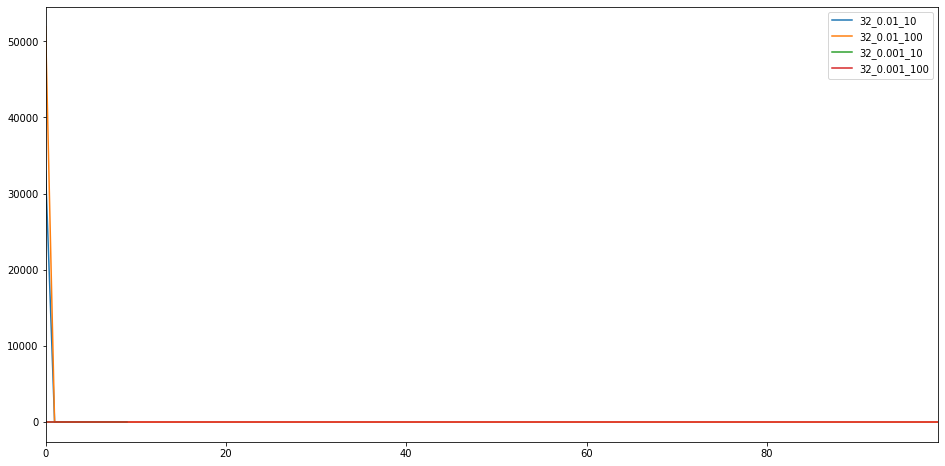

In [9]:
loss_memory, val_loss_memory = model_benchmark(dat_weekends, epochs_list, lr_list, batchsize_list)
loss_memory.plot(figsize=[16,8])

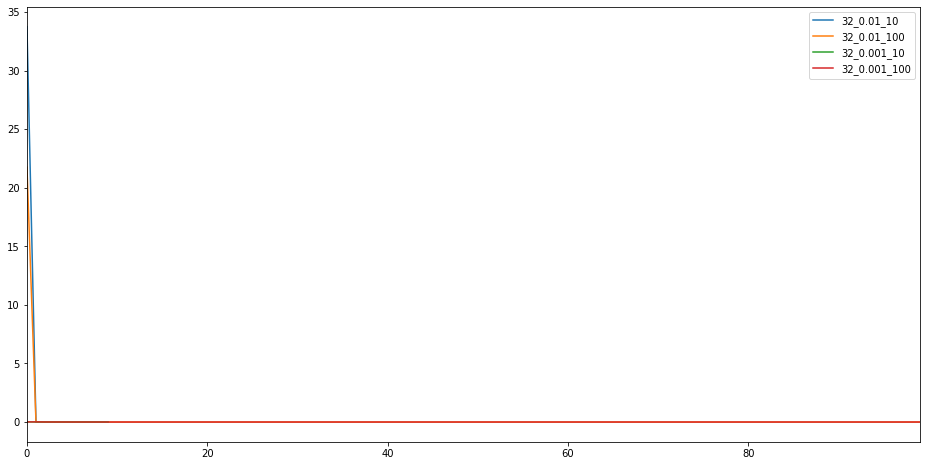

In [10]:
val_loss_memory.plot(figsize=[16,8])

In [1]:
fname = "data/gt-weekly.zip"
dscol = 'time'
ycols = ['i1','i2','i3','i4','i5','i6','i7','i8','i9','i10']

In [2]:
from preprocessing.preprocessor import LoadData, FindFrequency, PeriodDetect, AlignData, DropExtrema, Normalizer, FillGap, GenerateInput
from modeling.pytorch_ae_benchmark import Benchmark
from pipeline import Pipeline

benchmark_list = [
    LoadData(fname, dscol, ycols),
    FindFrequency(),
    PeriodDetect(),
    AlignData(),
    DropExtrema(),
    Normalizer(),
    FillGap(),
    GenerateInput(),
    Benchmark()
]
benchmark_pipeline = Pipeline(benchmark_list)
loss_memory, val_loss_memory = benchmark_pipeline.benchmark_transform()

Using TensorFlow backend.
/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])

/Users/preh0405/Desktop/chrono+/notebook


Finding frequency:   0%|          | 0/2 [00:00<?, ?it/s]

(25200, 10)
(10080, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs'])
dict_keys(['minfreq', 'colfreqs'])


Detecting Period:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/preh0405/opt/anaconda3/envs/chrono/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


(25200, 10)
(10080, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period'])
dict_keys(['minfreq', 'colfreqs', 'period'])


Aligning data:   0%|          | 0/2 [00:00<?, ?it/s]

(35279, 10)
(31679, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint'])


Dropping Extrema:   0%|          | 0/2 [00:00<?, ?it/s]

(35279, 10)
(31679, 10)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint'])


Normalising:   0%|          | 0/2 [00:00<?, ?it/s]

(35279, 11)
(31679, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms'])


Filling gap:   0%|          | 0/2 [00:00<?, ?it/s]

ok10
ok20
ok11
ok21
(35279, 11)
(31679, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
(35279, 11)
(31679, 11)
dict_keys(['ycols', 'dscol', 'weekdays', 'weekends', 'orient'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])
dict_keys(['minfreq', 'colfreqs', 'period', 'anchors', 'zeropoint', 'modnorms', 'profile', 'time_index'])


Generating Input:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch number:0 train_loss: 62987.39349872867 val_loss: 0.49597728078178466
epoch number:0 train_loss: 42505.93003256288 val_loss: 1.1338004380391462


  0%|          | 0/2 [00:00<?, ?it/s]

epoch number:0 train_loss: 0.06091630789968702 val_loss: 0.00821971908159953
epoch number:0 train_loss: 0.05566460887591044 val_loss: 0.005763090786864203


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch number:0 train_loss: 44361.6904278649 val_loss: 22.792758505428836
epoch number:0 train_loss: 28462.16506157443 val_loss: 24.459942895113123


  0%|          | 0/2 [00:00<?, ?it/s]

epoch number:0 train_loss: 0.022918259724974632 val_loss: 0.00892356982074282
epoch number:0 train_loss: 0.02481930609792471 val_loss: 0.009493205554009114


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch number:0 train_loss: 53747.28930960099 val_loss: 29.84418680391744
epoch number:0 train_loss: 53409.81706309981 val_loss: 45.007471800864735


  0%|          | 0/2 [00:00<?, ?it/s]

epoch number:0 train_loss: 0.05297853218184577 val_loss: 0.020350577720818577
epoch number:0 train_loss: 0.04517741335762872 val_loss: 0.01711944465592355


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

epoch number:0 train_loss: 33513.85216756724 val_loss: 21.898890944173427
epoch number:0 train_loss: 37574.77012532763 val_loss: 20.138082625161257


  0%|          | 0/2 [00:00<?, ?it/s]

epoch number:0 train_loss: 0.026730000972747803 val_loss: 0.010222124508251908
epoch number:0 train_loss: 0.02584808971732855 val_loss: 0.010128381664412925


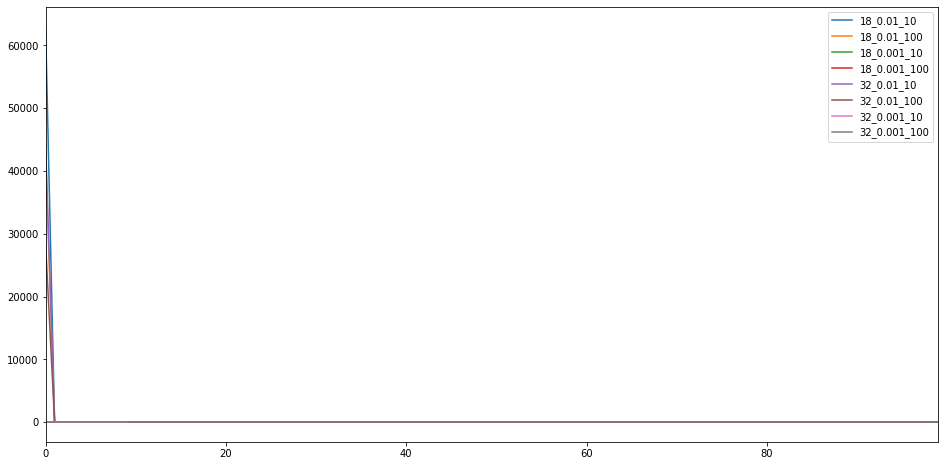

In [3]:
#weekdays
loss_memory[0].plot(figsize=[16,8])

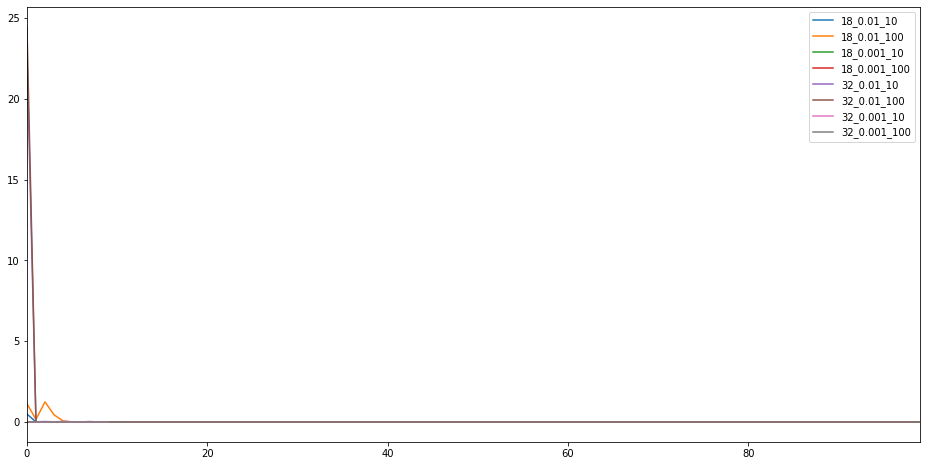

In [4]:
val_loss_memory[0].plot(figsize=[16,8])

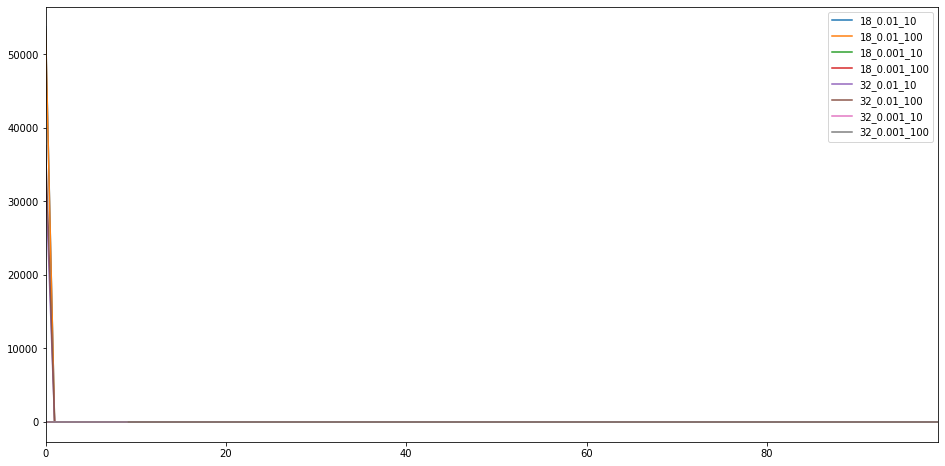

In [5]:
loss_memory[1].plot(figsize=[16,8])

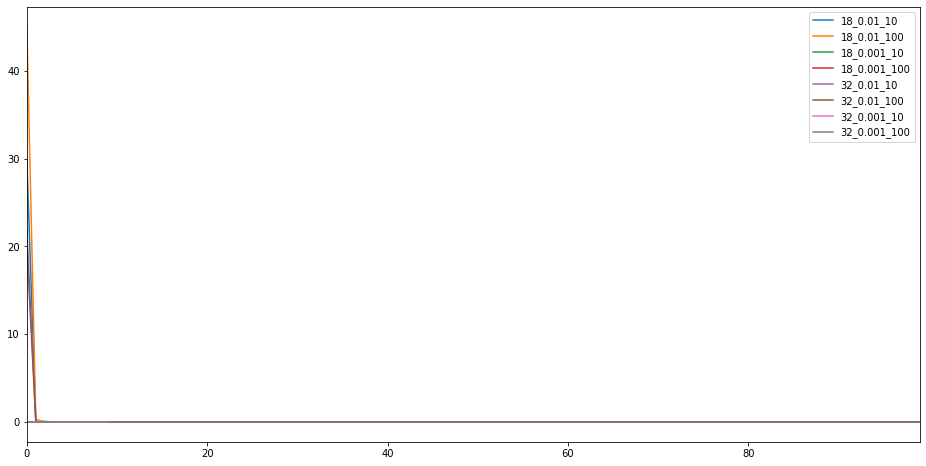

In [6]:
val_loss_memory[1].plot(figsize=[16,8])